# Comparison with SIB on SI model
SIB: https://www.nature.com/articles/srep27538, https://github.com/sibyl-team/sib

In [275]:
using MatrixProductBP, MatrixProductBP.Models
using Graphs, Plots, Printf, IndexedGraphs, Statistics
import ProgressMeter;
ProgressMeter.ijulia_behavior(:clear);

In [288]:
using PyCall, SparseArrays

ENV["PYTHON"] = "/home/crotti/miniconda3/bin/python"

@pyimport sib

# convert ϕ's into observations for sib
function sib_SIR_tests(ϕ::Vector{Vector{Vector{F}}}) where {F}
    N = length(ϕ)
    T = length(ϕ[1]) - 1 
    map((i,t) for i in 1:N for t in 1:T+1) do (i,t)
        (i - 1, sib.Test(ϕ[i][t]...), t - 1)
    end
end


function sib_SIR(T::Integer, g::IndexedGraph, ϕ, λ, ρ;
    maxiter=400, tol=1e-14)
    γ = ϕ[1][1][INFECTED]
    @assert all(isequal(γ), ϕᵢ[1][INFECTED] for ϕᵢ in ϕ)
    contacts = [(src(e) - 1, dst(e) - 1, t - 1, λ) for t in 1:T for e in edges(g)]
    append!(contacts, [(dst(e) - 1, src(e) - 1, t - 1, λ) for t in 1:T for e in edges(g)])
    sort!(contacts, by=x -> x[3])
    tests = sib_SIR_tests(ϕ)
    prob_r = sib.PiecewiseLinear(@pycall sib.RealParams([d > 0 ? exp((d-1)*(log(1 - ρ))) : 1.0 for d=0:3T])::Any)
    params = sib.Params(prob_r=prob_r, pseed=γ / (2 - γ), psus=(1 - γ) / (2 - γ), pautoinf=0.0)
    f = sib.FactorGraph(contacts=contacts, tests=tests, params=params)
    sib.iterate(f, maxit=maxiter, tol=tol)
    sib.iterate(f, maxit=maxiter, damping=0.5, tol=tol)
    sib.iterate(f, maxit=maxiter, damping=0.9, tol=tol)
    marginals_sib = map(f.nodes) do i
        map(1:T+1) do t
            sib.marginal_t(i, (t - 1))
        end
    end

    F_bethe = -f.loglikelihood() - N * log(2 - γ)

    return marginals_sib, F_bethe, f
end

sib_SIR (generic function with 1 method)

In [289]:
T = 10
N = 30
k = 3
gg = random_regular_graph(N, k)
g = IndexedGraph(gg)
λ = 0.3
ρ = 0.2
γ = 0.1
σ = 0.0 # SIR
sirs = SIRS(g, λ, ρ, σ, T; γ);

In [290]:
bp = mpbp(sirs)

nobs = N
draw_node_observations!(bp, nobs, times=5)
cb = CB_BP(bp);

In [291]:
iters, cb = iterate!(bp, maxiter=100; svd_trunc=TruncBond(4), cb, tol=1e-6);
iters, cb = iterate!(bp, maxiter=100; svd_trunc=TruncBond(6), cb, tol=1e-6);
iters, cb = iterate!(bp, maxiter=100; svd_trunc=TruncBond(8), cb, tol=1e-6);

Running MPBP: iter 14 	 Time: 0:00:21
  Δ:  2.4026327754808366e-7

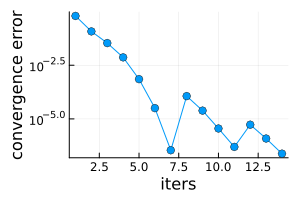

In [292]:
pl_err = plot(cb.Δs, ylabel="convergence error", xlabel="iters", m=:o, yaxis=:log10,
    size=(300, 200), label="")

In [293]:
fe_bp = bethe_free_energy(bp)
b_bp = beliefs(bp)
p_bp = [[bbb[2] for bbb in bb] for bb in b_bp];

Run sib

In [294]:
b_sib, fe_sib, f = sib_SIR(T, g, bp.ϕ, λ, ρ);

LoadError: BoundsError: attempt to access 11-element Vector{Vector{Float64}} at index [12]

In [ ]:
p_sib = [[bbb[2] for bbb in bb] for bb in b_sib];

In [ ]:
[(p_bp[1][t], p_sib[1][t]) for t = 1:T]

10-element Vector{Tuple{Float64, Float64}}:
 (0.03128938943382771, 0.01060192551761796)
 (0.06014325044597428, 0.025007755872596182)
 (0.10058340013027484, 0.049361387173757154)
 (0.16175912572308285, 0.09308097636651302)
 (0.24919658591479027, 0.1647891264305722)
 (0.36482818453877897, 0.27199610102079563)
 (0.5042591892824141, 0.41605932431649983)
 (0.6544528836957163, 0.5856812358460209)
 (0.7956754330035076, 0.7545204640394809)
 (0.9111680145251626, 0.8940199776185199)

SI on random regular graph N=30, k=3. P(S→I)=0.3.
30 random observations.


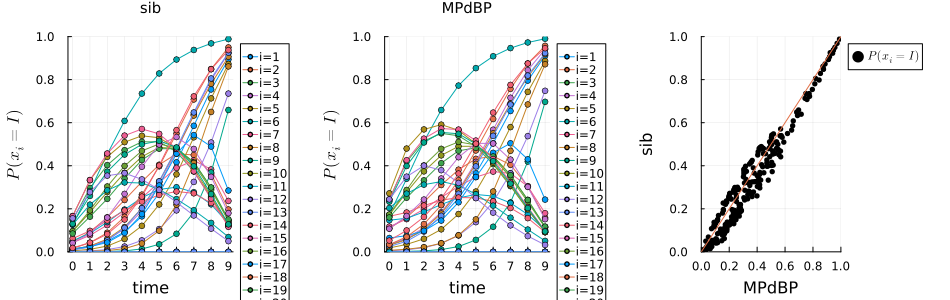

In [ ]:
pl_sib = plot(xlabel="time", ylabel="\$P(x_i=I)\$", xticks=0:1:T-1, title="sib", yrange=(0, 1))
for i in 1:N
    plot!(pl_sib, 0:T-1, p_sib[i], label="i=$i", m=:o, ms=3, lw=1)
end
pl_bp = plot(xlabel="time", ylabel="\$P(x_i=I)\$", xticks=0:1:T-1, title="MPdBP", yrange=(0, 1))
for i in 1:N
    plot!(pl_bp, 0:T-1, p_bp[i][1:T], label="i=$i", m=:o, ms=3, lw=1, yrange=[0, 1])
end
println("SI on random regular graph N=$N, k=$k. P(S→I)=$λ.")
println("$nobs random observations.")
#println("Max matrix size: ", svd_trunc.mprime, "x", svd_trunc.mprime)
pl_sc = scatter(reduce(vcat, [p[1:end-1] for p in p_bp]), reduce(vcat, p_sib), xlabel="MPdBP",
    ylabel="sib", label="\$P(x_i=I)\$", ms=3, c=:black, legend=:outertopright, xrange=(0, 1), yrange=(0, 1))
plot!(pl_sc, identity, label="", size=(300, 300))
plot(pl_sib, pl_bp, pl_sc, titlefontsize=10, size=(950, 300), legend=:outertopright,
    margin=5Plots.mm, layout=(1, 3))

Compare estimates for the free energy

In [ ]:
fe_bp, fe_sib

(27.042279653507478, 35.026895784329)

In [ ]:
(fe_bp - fe_sib) / fe_sib

-0.22795671589013125